In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()

In [82]:
from sklearn.datasets import load_boston
df = pd.read_csv(load_boston()['filename'],skiprows=1)
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6


In [83]:
X = np.array( df)[:,:-1]
y = np.array( df)[:,-1]
X.shape, y.shape

((506, 13), (506,))

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=255)
X_test_final , y_test_final  = X_test , y_test # Финальный тест

In [85]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

### Построим функцию градиентного бустинга
Функция для регрессии, стало быть Функция потерь - среднеквадратичная ошибка.  
Основа бустинга на дерево глубиной 1 ( можно менять).  
Cтоп критерий - когда ошибка на тестовой выборке (отложенной выборка) начнет расти.  

Разбиваю выборку на 3 части (одна часть для отложенной выборки во время обучения градиентного буста).

In [87]:
def gradient_boost(X,y, depth = 3,lr=0.1,iterations = 100, debug = True):
    '''
        Функция возвращает градиентный буст из деревьев, 
        Внутри дробит массив X и целевой признак y на train test, test Используется как отложенная выборка. 
        depth - глубина i дерева
        lr - learning rate с которым добавляется новое i дерево
        iterations - сколько деревьев построит модель
        stop criteria - Критерий останова. Когда ошибка модели на отложенной выборке (не на train) начнет расти. 
        debug - выводить текстовую валидацию 
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3,random_state=255)
    X_train.shape, X_test.shape

    b1 = DecisionTreeRegressor(max_depth=1,random_state=255)
    b1.fit(X_train, y_train) # Создали пень

    
    MSE_test =[]
    MSE_train = []
    s = np.array([])
    

    gamma = [1]
    b_n_array = [b1]

    y_pred = b1.predict(X_train)  # получим Функцию потерь (MSE), ошибку (s1) и градиент функции потерь на ОБУЧАЮЩЕЙ выборке
    MSE_train.append( mean_squared_error(y_train,y_pred) ) # Функция потерь (MSE)
    grad_MSE = (y_pred - y_train)/len(y_train)  # анти-градиент функции потерь
    s =  - grad_MSE     # ошибка (s1)- это начения, которые должен принимать новый алгоритм на объектах ОБУЧАЮЩЕЙ выборки

    y_pred_test = b1.predict(X_test)
    MSE_test.append( mean_squared_error(y_test, y_pred_test) )
    
    if debug: print('MSE train \t|\t MSE test')
    if debug: print('-'*40)

    for j in range(iterations):
        b_n_MSE = []
        b_n_model = []

        # Находим наилучшее дерево - максимально снижающее ошибку s
        for i in range(20):
            b_n = DecisionTreeRegressor(max_depth= depth)
            b_n.fit(X_train, s)
            b_n_model.append(b_n)
            y_pred = b_n.predict(X_train)
            b_n_MSE.append(mean_squared_error(s,y_pred))

        b_n_best = b_n_model[np.array(b_n_MSE).argmin()] # Находим алгоритм, который выдает минимальную среднеквадратичную ошибку между s1 и y_pred by b1
        b_n_array.append(b_n_best)
        b_n_MSE_best = np.array(b_n_MSE).min()           # Находим минимальную среднеквадратичную ошибку вышеуказанного алгоритма  

        gamma_n = lr # можно использовать с нарастающим эффектом (np.log( (1-b_n_MSE_best)/b_n_MSE_best )/2) # Подставляем learning rate 
        gamma.append(gamma_n)

        y_pred = get_gradient_boost_predict(X_train,gamma,b_n_array)


        MSE_train.append( mean_squared_error(y_train,y_pred) )

        y_pred_test = get_gradient_boost_predict(X_test,gamma,b_n_array)
        MSE_test.append( mean_squared_error(y_test, y_pred_test) )
        
        if debug and (j%30==0) :print('{0:.4f} \t|\t {1:.4f} '.format(MSE_train[-1],MSE_test[-1] ))
        
        #Критерий останова. Когда ошибка на тесте начинает расти - значит модель переобучилась
        if (MSE_test[-1] > MSE_test[-2]) : break
        
    if debug: print('-'*40)    
    if debug: print(f'the first MSE train = {MSE_train[0]}, the last MSE train = { MSE_train[-1]} ')
    if debug: print(f'the first MSE test= {MSE_test[0]}, the last MSE test = { MSE_test[-1]} ')
    if debug: print(f'Total iterations = {j}')
    
    
    # Нарисуем как менялись MSE train и MSE test. Чтобы определить когда модель переобучилась
    plt.plot(range(len(MSE_train)),MSE_train, 'g--', label='MSE_train')
    plt.plot(range(len(MSE_train)),MSE_test, 'b-', label='MSE_test')
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.show()
    return gamma, b_n_array     

In [7]:
def get_gradient_boost_predict(x,gamma1, b_n_array1):
    y_predicted = np.zeros(len(x))
    for i in range(len(gamma1)):
        y_predicted += gamma1[i]*b_n_array1[i].predict(x)
    return y_predicted

MSE train 	|	 MSE test
----------------------------------------
46.0522 	|	 45.5610 
38.5180 	|	 36.5073 
34.2158 	|	 30.4956 
33.1455 	|	 27.5258 
35.3072 	|	 27.5980 
----------------------------------------
the first MSE train = 46.35900743879473, the last MSE train = 35.30716055740541 
the first MSE test= 45.91521786630929, the last MSE test = 27.59796282697427 
Total iterations = 120


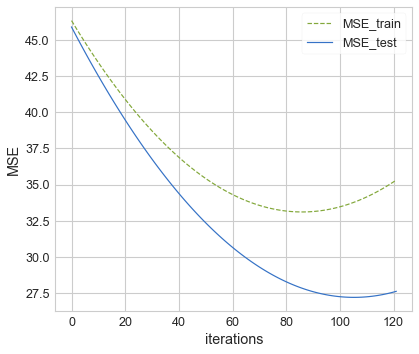

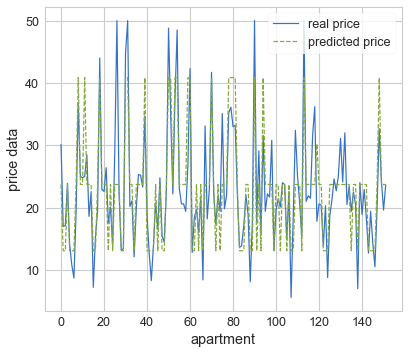

In [8]:
gamma, b_n_array = gradient_boost(X,y, depth = 1,iterations=500, debug = True)

y_pred_final = get_gradient_boost_predict(X_test_final,gamma, b_n_array)

#Построим график y_pred и y_test на выборке отложенной в самом начале.  
plt.plot(range(len(y_test_final)), y_test_final,'-', label='real price' )
plt.plot(range(len(y_test_final)), y_pred_final,'--', label='predicted price'  )
plt.xlabel('apartment')
plt.ylabel('price data')
plt.legend(loc='best')

Видно по последнему графику, что модель чуть переобучилась.  
Также это можно заметить на первом графике MSE train/test - ошибка на train и test начала расти.  
попробуем снизить шаг буста (На графике выше шаг буста адаптивный - увеличивается если MSE снижается) и снизим глубину i дерева 

MSE train 	|	 MSE test
----------------------------------------
46.3066 	|	 45.8548 
44.7832 	|	 44.0875 
43.3531 	|	 42.4080 
42.0164 	|	 40.8164 
40.7730 	|	 39.3126 
39.6229 	|	 37.8966 
38.5661 	|	 36.5685 
37.6026 	|	 35.3282 
36.7325 	|	 34.1757 
35.9557 	|	 33.1111 
35.2722 	|	 32.1343 
34.6820 	|	 31.2454 
34.1852 	|	 30.4443 
33.7817 	|	 29.7310 
33.4715 	|	 29.1056 
33.2546 	|	 28.5680 
33.1311 	|	 28.1183 
----------------------------------------
the first MSE train = 46.35900743879473, the last MSE train = 33.101113156125216 
the first MSE test= 45.91521786630929, the last MSE test = 27.87887083025897 
Total iterations = 499


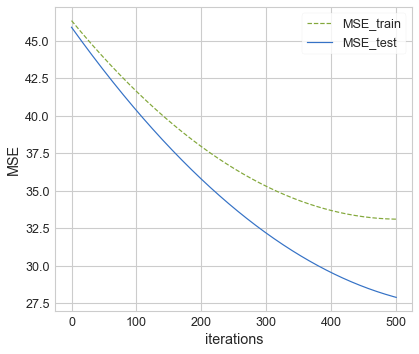

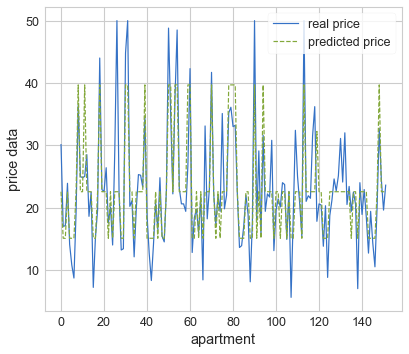

In [12]:
gamma, b_n_array = gradient_boost(X,y, lr=0.7 ,depth = 1,iterations=500, debug = True)

y_pred_final = get_gradient_boost_predict(X_test_final,gamma, b_n_array)

#Построим график y_pred и y_test на выборке отложенной в самом начале.  
plt.plot(range(len(y_test_final)), y_test_final,'-', label='real price' )
plt.plot(range(len(y_test_final)), y_pred_final,'--', label='predicted price'  )
plt.xlabel('apartment')
plt.ylabel('price data')
plt.legend(loc='best')

Ошибка медленно падает, но не приходит в точку останова.  
Еще увеличим скорость обучения.

MSE train 	|	 MSE test
----------------------------------------
46.1724 	|	 45.6999 
41.1888 	|	 39.8183 
37.3955 	|	 35.0570 
34.7926 	|	 31.4162 
33.3801 	|	 28.8957 
33.1579 	|	 27.4956 
----------------------------------------
the first MSE train = 46.35900743879473, the last MSE train = 33.79363444966178 
the first MSE test= 45.91521786630929, the last MSE test = 27.180930436603195 
Total iterations = 173


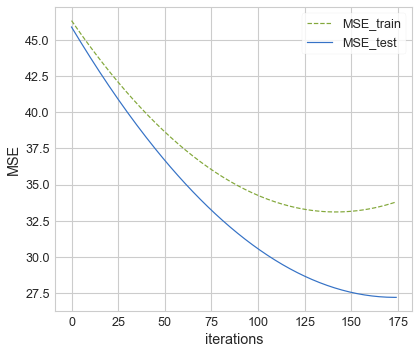

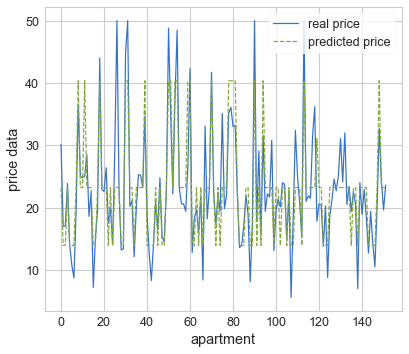

In [88]:
gamma, b_n_array = gradient_boost(X,y, lr=2.5 ,depth = 1,iterations=500, debug = True)

y_pred_final = get_gradient_boost_predict(X_test_final,gamma, b_n_array)

#Построим график y_pred и y_test на выборке отложенной в самом начале.  
plt.plot(range(len(y_test_final)), y_test_final,'-', label='real price' )
plt.plot(range(len(y_test_final)), y_pred_final,'--', label='predicted price'  )
plt.xlabel('apartment')
plt.ylabel('price data')
plt.legend(loc='best')

### ДЗ 
Теперь решаем задачу регрессии - предскажем цены на недвижимость. 
- Использовать датасет www.kaggle.com...iques/data (train.csv)
- Построить случайный лес, вывести важность признаков
- Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
- В качестве решения: Jupyter notebook с кодом, комментариями и графиками





Доп. выполню то же самое на :
1. градиентном бустинге
1. xgboost
1. adaboost

#### Загрузим и отсортируем массивы данных. 

In [261]:
df = pd.read_csv('train.csv',index_col='Id')
df.tail(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [262]:
for i in df.columns:
    if df[i].isna().sum() == 0: continue
    print(f' column {i}, missed values= {df[i].isna().sum()}')    

 column LotFrontage, missed values= 259
 column Alley, missed values= 1369
 column MasVnrType, missed values= 8
 column MasVnrArea, missed values= 8
 column BsmtQual, missed values= 37
 column BsmtCond, missed values= 37
 column BsmtExposure, missed values= 38
 column BsmtFinType1, missed values= 37
 column BsmtFinType2, missed values= 38
 column Electrical, missed values= 1
 column FireplaceQu, missed values= 690
 column GarageType, missed values= 81
 column GarageYrBlt, missed values= 81
 column GarageFinish, missed values= 81
 column GarageQual, missed values= 81
 column GarageCond, missed values= 81
 column PoolQC, missed values= 1453
 column Fence, missed values= 1179
 column MiscFeature, missed values= 1406


In [263]:
# Соберем все категории
categories = list(df.columns[df.dtypes == object])

In [264]:
# Закодируем пропуски в категорийных столбцах строкой 'nan'
df[categories] = df[categories].fillna('nan')

In [265]:
# Соберем все остальные столбцы, кроме категорийных
numerical = [i for i in list(df.columns) if i not in categories]

In [266]:
# вот еще категорийные признаки, кроме этих [LowQualFinSF , 3SsnPorch , PoolArea ]: 
for i in numerical:
    if df[i].nunique() > 70: continue
    print(i, df[i].unique(), df[i].nunique())
    print('-'*55)
    categories.append(i) 

MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40] 15
-------------------------------------------------------
OverallQual [ 7  6  8  5  9  4 10  3  1  2] 10
-------------------------------------------------------
OverallCond [5 8 6 7 4 2 3 9 1] 9
-------------------------------------------------------
YearRemodAdd [2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974] 61
-------------------------------------------------------
LowQualFinSF [  0 360 513 234 528 572 144 392 371 390 420 473 156 515  80  53 232 481
 120 514 397 479 205 384] 24
-------------------------------------------------------
BsmtFullBath [1 0 2 3] 4
-------------------------------------------------------
BsmtHalfBath [0 1 2] 3
-----------------

In [267]:
# Уберем эти столбцы ['LowQualFinSF' , '3SsnPorch' , 'PoolArea'], хоть в них значений мало, они числовые признаки
categories  = [i for i in categories if i not in ['LowQualFinSF' , '3SsnPorch' , 'PoolArea']]

In [268]:
# Соберем оставшиеся столбцы [все столбцы - категорийные], учтем, что есть столбец ['SalePrice'] - целевой признак у.
numerical = [i for i in list(df.columns) if i not in categories+['SalePrice']]

In [269]:
# ['SalePrice'] - целевой признак у.
y_train = df['SalePrice']

In [270]:
# Отберем категорийные признаки у которых признаков меньше 30. 
# Чтобы не создавать столбцы с огромным количеством признаков
categories_less30 = [i for i in categories if df[i].nunique()<30]

In [271]:
# Уберем бинарные категории
categories_less30_binary = []
for i in categories_less30:
    if df[i].nunique() ==2 : 
        print(i)
        print('-'*55)
        categories_less30_binary.append(i)
print(categories_less30_binary)
categories_less30 = [i for i in categories if i not in categories_less30_binary]

Street
-------------------------------------------------------
Utilities
-------------------------------------------------------
CentralAir
-------------------------------------------------------
['Street', 'Utilities', 'CentralAir']


In [272]:
# Создаем дамми:
dummy = pd.get_dummies(df[categories_less30], columns=categories_less30)

In [273]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [275]:
# создаем бинарные столбцы
dummy_binary = pd.DataFrame({i:le.fit_transform( df[i] ) for i in categories_less30_binary }, index=range(1,len(df)+1))
dummy_binary_descr = {i:(le.fit( df[i] ).classes_) for i in categories_less30_binary }
dummy_binary_descr

{'Street': array(['Grvl', 'Pave'], dtype=object),
 'Utilities': array(['AllPub', 'NoSeWa'], dtype=object),
 'CentralAir': array(['N', 'Y'], dtype=object)}

In [276]:
# Создаем Х - массив признаков
X_train = pd.concat( [df[numerical].fillna(-777),dummy_binary, dummy],axis=1)

In [277]:
X_train.head(2)

,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
1,65.0,8450,2003,196.0,706,0,150,856,856,854,...,0,0,0,0,0,0,0,1,0,0
2,80.0,9600,1976,0.0,978,0,284,1262,1262,0,...,0,0,0,0,0,0,1,0,0,0


#### Повторим то же самое для Test.csv

In [109]:
df = pd.read_csv('test.csv',index_col='Id')
df.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [110]:
# Соберем все категории
categories = list(df.columns[df.dtypes == object])

In [111]:
# Закодируем пропуски в категорийных столбцах строкой 'nan'
df[categories] = df[categories].fillna('nan')

In [112]:
# Соберем все остальные столбцы, кроме категорийных
numerical = [i for i in list(df.columns) if i not in categories]

In [113]:
# вот еще категорийные признаки, кроме этих [LowQualFinSF , 3SsnPorch , PoolArea ]: 
for i in numerical:
    if df[i].nunique() > 70: continue
    categories.append(i) 

In [114]:
# Уберем эти столбцы ['LowQualFinSF' , '3SsnPorch' , 'PoolArea'], хоть в них значений мало, они числовые признаки
categories  = [i for i in categories if i not in ['LowQualFinSF' , '3SsnPorch' , 'PoolArea']]

In [115]:
# Соберем оставшиеся столбцы [все столбцы - категорийные]
numerical = [i for i in list(df.columns) if i not in categories]

In [116]:
# Отберем категорийные признаки у которых признаков меньше 30. 
# Чтобы не создавать столбцы с огромным количеством признаков
categories_less30 = [i for i in categories if df[i].nunique()<30]

In [117]:
# Уберем бинарные категории
categories_less30_binary = []
for i in categories_less30:
    if df[i].nunique() ==2 : 
        categories_less30_binary.append(i)
categories_less30 = [i for i in categories if i not in categories_less30_binary]

In [118]:
# Создаем дамми:
dummy = pd.get_dummies(df[categories_less30], columns=categories_less30)

In [187]:
# создаем бинарные дамми
dummy_binary = pd.DataFrame({i:le.fit_transform( df[i] ) for i in categories_less30_binary },index=range(1461,1461+len(df)) )
dummy_binary_descr = {i:(le.fit( df[i] ).classes_) for i in categories_less30_binary }

In [189]:
# Создаем Х - массив признаков
X_test = pd.concat( [df[numerical].fillna(-777),dummy_binary, dummy],axis=1).loc[1460:]

In [190]:
X_test.head(2)

,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
1461,80.0,11622,1961,0.0,468.0,144.0,270.0,882.0,896,0,...,0,0,0,0,0,0,0,0,0,1
1462,81.0,14267,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,...,0,0,0,0,0,0,0,0,0,1


#### Теперь добавим целевой признак y_test:

In [122]:
y = pd.read_csv('sample_submission.csv')
y.head(2)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989


In [123]:
# отсортируем по ['Id']
y.sort_values(['Id'], ascending=True, inplace=True)

# Запишем в целевую переменную y_test
y_test = y['SalePrice']

Итого у нас есть: 
- X_train
- y_train
- X_test
- y_test

In [278]:
# Проверим размерность:
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((1460, 465), (1460,), (1459, 506), (1459,))

Количество столбцов X_train  и X_test не совпадает.  
заполним недостающие нулями.

In [279]:
# Уравняем размер столбцов X_train  и X_test .
# добавим недостающие столбцы с нулевыми значениями 
additional_columns_in_X_train = [i for i in X_train.columns if i not in X_test.columns]
for i in additional_columns_in_X_train:
    X_test[i] = np.zeros( len(X_test), dtype=int) 
    
additional_columns_in_X_test = [i for i in X_test.columns if i not in X_train.columns]
for i in additional_columns_in_X_test:
    X_train[i] = np.zeros( len(X_train), dtype=int) 

In [280]:
#проверка
[i for i in X_train.columns if i not in X_test.columns], [i for i in X_test.columns if i not in X_train.columns]

([], [])

In [281]:
# Проверка на NaN мало ли
for column in X_test.columns:
    if X_test[column].isna().sum() == 0: continue
    print(column, X_test[column].isna().sum())

In [282]:
# Проверка на NaN мало ли
for column in X_train.columns:
    if X_train[column].isna().sum() == 0: continue
    print(column, X_train[column].isna().sum())

### ДЗ. №2 Построить случайный лес, вывести важность признаков

In [249]:
#bootstrap - создем 10 случайных bootstrap выборок для 10 деревьев 
samples = 10 # 10 деревьев в случайном лесу
length = len(X_train)
bootstrap_samples = []
bootstrap_y = []


for i in range(samples):
    sample = np.random.choice(range(1,length,1),length,replace=True)
    
    bootstrap_samples.append( X_train.loc[sample,:]  )
    bootstrap_y.append( y_train[sample] )

In [295]:
# соберем 10 деревьев
models = []
for i in range(samples):
    b = DecisionTreeRegressor(max_depth=None)
    b.fit(bootstrap_samples[i],bootstrap_y[i])
    models.append(b)

In [230]:
# предскажем на X_test выборке:
def predict(tree_models,X_test_array):
    prediction = None 
    
    for b in tree_models:
        if prediction is None: 
            prediction = b.predict(X_test_array).reshape((-1,1))
        else: 
            prediction = np.hstack( (prediction, b.predict(X_test_array).reshape((-1,1)) )  )

    result = []
    for i in prediction:
        result.append( np.mean(i) )
    return np.array(result)

In [296]:
# посмотрим результаты
y_pred = predict(models,X_test)
print( mean_squared_error(y_test,y_pred) )
print( ' Each Model Mean:')
result = []
for b in models:
    result.append(mean_squared_error(y_test, b.predict(X_test)) )
    #print( result[-1] )
print(np.mean(result))

938012652.863349
 Each Model Mean:
2717241492.9788227


Видно, что случайный лес работает и позволил снизить ошибку в 3 раза

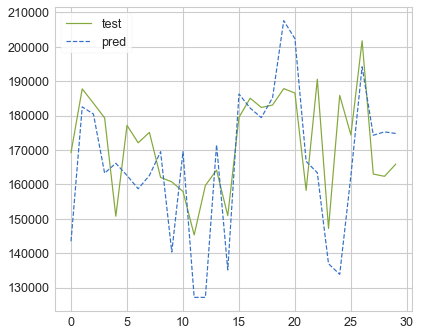

In [297]:
# Выведем на графике первые 30 точек
plt.plot(range(30), y_test[:30],'g-',label = 'test' )
plt.plot(range(30), y_pred[:30],'b--',label = 'pred')
plt.legend(loc='best')

Видно, что случайный лес переобучен
### Сделаем то же самое на функции из sklearn

In [256]:
from sklearn.ensemble import RandomForestRegressor

In [298]:
random_forest_reg = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None, n_jobs=-1)
random_forest_reg.fit(X_train,y_train)
y_pred_rf = random_forest_reg.predict(X_test)
print('Random forest from sklearn result = \t{0:.0f}'.format(mean_squared_error(y_test,y_pred_rf)) )
print('Random forest written result =  \t{0:.0f}'.format(mean_squared_error(y_test,y_pred) ) )

Random forest from sklearn result = 	1864657977
Random forest written result =  	938012653


То есть, написанная здесь функция случайного леса дает лучше **в 2 раза** значения, чем такая же функция из sklearn 

In [310]:
# Построим важность признаков
features_rf = pd.Series(random_forest_reg.feature_importances_, index=X_train.columns)
features_rf.sort_values(ascending=False, inplace=True)
features_rf.head(10)

GarageCars_3      0.289565
GrLivArea         0.198253
ExterQual_TA      0.141392
TotalBsmtSF       0.061254
BsmtFinSF1        0.038080
KitchenQual_Ex    0.029474
2ndFlrSF          0.026810
1stFlrSF          0.022299
LotArea           0.018075
YearBuilt         0.013822
dtype: float64

In [307]:
# Построим важность признаков на написанной функции:
def feature_importances_(tree_models):
    features = None 
    
    for b in tree_models:
        if features is None: 
            features = b.feature_importances_.reshape((-1,1))
        else: 
            features = np.hstack( (features, b.feature_importances_.reshape((-1,1)) )  )

    result = []
    for i in features:
        result.append( np.mean(i) )
    return np.array(result)

In [314]:
features_from_f = pd.Series(feature_importances_(models ), index=X_train.columns)
features_from_f.sort_values(ascending=False, inplace=True)
features_from_f.head()

GarageCars_3    0.358476
GrLivArea       0.214850
ExterQual_TA    0.063719
1stFlrSF        0.056072
YearBuilt       0.039268
dtype: float64

In [329]:
features = pd.DataFrame(data=[features_from_f,features_rf], index=[['features_written_function','features_sklearn_random_forest']])
features = features.T
features.head()

,features_written_function,features_sklearn_random_forest
GarageCars_3,0.358476,0.289565
GrLivArea,0.214850,0.198253
ExterQual_TA,0.063719,0.141392
1stFlrSF,0.056072,0.022299
YearBuilt,0.039268,0.013822


### ДЗ. №3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

In [330]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

In [346]:
regressor = StackingRegressor(
    [
        ('dt5', DecisionTreeRegressor(max_depth=5)),
        ('dt7', DecisionTreeRegressor(max_depth=7)),
        ('dt10', DecisionTreeRegressor(max_depth=10)),
        ('dt11', DecisionTreeRegressor(max_depth=11)),
        ('dt15', DecisionTreeRegressor(max_depth=15)),
        ('dtNone', DecisionTreeRegressor(max_depth=None))
    ],
LinearRegression())

In [347]:
regressor.fit(X_train,y_train)
y_pred_stacking = regressor.predict(X_test)
mean_squared_error(y_test, y_pred_stacking)

1833252853.5998356

<AxesSubplot:>

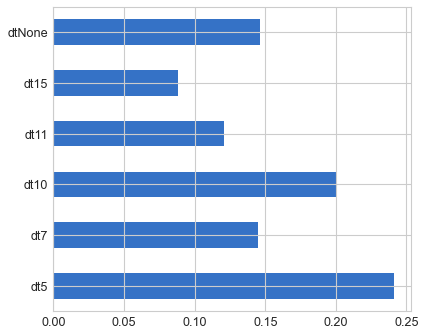

In [348]:
pd.Series(regressor.final_estimator_.coef_, index=regressor.named_estimators_.keys()).plot(kind='barh')

Больший вклад вносит дерево с глубиной 5

### Стекинг напишем функцию:

In [368]:
X,y = X_train,y_train
X_train, X_test_first, y_train, y_test_first = train_test_split(X_train, y_train , test_size=0.3,random_state=255,)

In [353]:
#bootstrap - создем 10 случайных bootstrap выборок для 10 деревьев 
samples = 10 # 10 деревьев в случайном лесу
length = len(X_train)
bootstrap_samples = []
bootstrap_y = []


for i in range(samples):
    sample = np.random.choice(X_train.index,length,replace=True)
    
    bootstrap_samples.append( X_train.loc[sample,:]  )
    bootstrap_y.append( y_train[sample] )

In [354]:
# соберем 10 деревьев
models = []
for i in range(samples):
    b = DecisionTreeRegressor(max_depth=None)
    b.fit(bootstrap_samples[i],bootstrap_y[i])
    models.append(b)

In [355]:
lin_reg = LinearRegression()
prediction = None 

for b in models:
    if prediction is None: 
        prediction = b.predict(X_test_first).reshape((-1,1))
    else: 
        prediction = np.hstack( (prediction, b.predict(X_test_first).reshape((-1,1)) )  )

lin_reg.fit(prediction, y_test_first)

LinearRegression()

In [359]:
# предскажем на X_test выборке:
def predict_with_lr(tree_models,X_test_array,lin_regres):
    prediction = None 
    
    for b in tree_models:
        if prediction is None: 
            prediction = b.predict(X_test_array).reshape((-1,1))
        else: 
            prediction = np.hstack( (prediction, b.predict(X_test_array).reshape((-1,1)) )  )

    return lin_regres.predict(prediction)

In [361]:
# посмотрим результаты
y_pred = predict_with_lr(models,X_test,lin_reg)
print( mean_squared_error(y_test,y_pred) )
print( ' Each Model Mean:')
result = []
for b in models:
    result.append(mean_squared_error(y_test, b.predict(X_test)) )
    #print( result[-1] )
print(np.mean(result))

3038480889.652186
 Each Model Mean:
3065869634.832046


С линейной моделью получается хуже результат, чем без неё. Нужно оптимизировать фолдами.

In [363]:
import xgboost as xgb

In [393]:
# загрузим X_train и y_train в DMatrix
dtrain = xgb.DMatrix(data=X_train, feature_names= X_train.columns, label=y_train, missing=-777)
dtest_first = xgb.DMatrix(data=X_test_first, feature_names= X_test_first.columns, label=y_test_first) # Отложенная выборка
dtest = xgb.DMatrix(data=X_test, feature_names= X_test_first.columns, label=y_test)

In [379]:
# Установим параметры 
param = {'max_depth': 5, 'eta': 1, 'objective': 'reg:squarederror', 'eval_metric':'rmse'} 

In [374]:
# Установим выборки для отслеживания прогресса:
evallist = [(dtest_first, 'eval'), (dtrain, 'train')]

In [394]:
# Старт обучения
num_round = 100
bst = xgb.train(param, dtrain, num_boost_round=num_round, evals=evallist,early_stopping_rounds=10)

[0]	eval-rmse:55943.98438	train-rmse:34928.16797
[1]	eval-rmse:52572.18359	train-rmse:27609.90820
[2]	eval-rmse:51304.00000	train-rmse:23155.77539
[3]	eval-rmse:51431.17578	train-rmse:21439.50781
[4]	eval-rmse:52469.58203	train-rmse:19558.61914
[5]	eval-rmse:52696.90234	train-rmse:18478.49219
[6]	eval-rmse:53277.58984	train-rmse:17564.34961
[7]	eval-rmse:52780.42969	train-rmse:15965.60547
[8]	eval-rmse:52666.09375	train-rmse:14865.20312
[9]	eval-rmse:53219.19141	train-rmse:13504.64648
[10]	eval-rmse:53485.30859	train-rmse:13057.33984
[11]	eval-rmse:53813.20312	train-rmse:12045.62793
[12]	eval-rmse:53578.06641	train-rmse:10640.51465
[13]	eval-rmse:53800.43359	train-rmse:10125.42481
[14]	eval-rmse:53894.29688	train-rmse:9656.76172
[15]	eval-rmse:53945.00000	train-rmse:9395.76172
[16]	eval-rmse:53833.58203	train-rmse:8703.90039
[17]	eval-rmse:53821.40625	train-rmse:8308.98828
[18]	eval-rmse:54128.29688	train-rmse:7867.12061
[19]	eval-rmse:54037.87891	train-rmse:7681.96875
[20]	eval-rmse:5

In [395]:
# Предсказание
ypred = bst.predict(dtest)
ypred_best_iteration = bst.predict(dtest, iteration_range=(0, bst.best_iteration))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

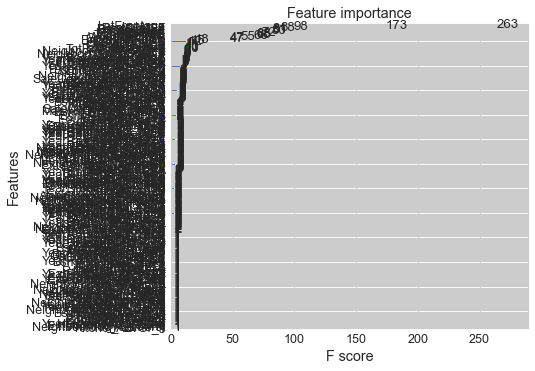

In [397]:
# Нарисовать график
xgb.plot_importance(bst)

<AxesSubplot:>

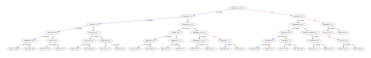

In [398]:
# Отрисовать дерево
xgb.plot_tree(bst, num_trees=2)

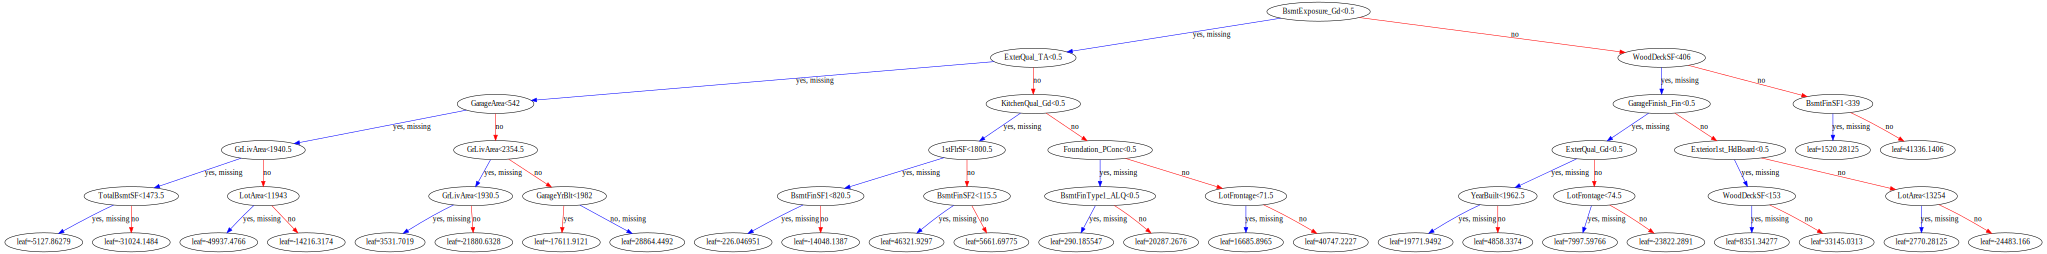

In [399]:
# Отрисовать дерево в grapviz
xgb.to_graphviz(bst, num_trees=2)

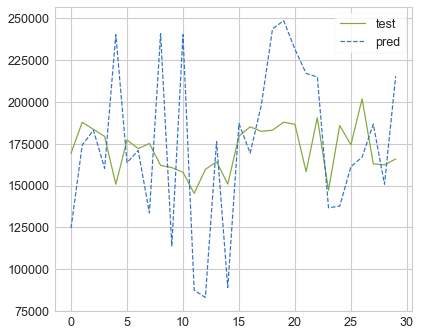

In [400]:
# Выведем на графике первые 30 точек
plt.plot(range(30), y_test[:30],'g-',label = 'test' )
plt.plot(range(30), y_pred[:30],'b--',label = 'pred')
plt.legend(loc='best')

In [396]:
mean_squared_error(y_test,y_pred)

3038480889.652186

Очень плохое предсказание от XG буста.

### Проверим на Gradient Boost функции:

In [403]:
X_train, y_train = X,y

MSE train 	|	 MSE test
----------------------------------------
3573168557.1771 	|	 5341326402.1968 
3182852615.0988 	|	 4820051121.4290 
2822346953.7291 	|	 4340045238.1623 
2491651573.0680 	|	 3903271945.3621 
2190766473.1156 	|	 3506758418.7345 
1919691653.8718 	|	 3152843152.1666 
1678427115.3366 	|	 2840138860.8250 
1466972857.5100 	|	 2569900820.2548 
1285328880.3921 	|	 2341523162.8448 
1133495183.9828 	|	 2154784134.3916 
1011471768.2821 	|	 2011260377.6508 
919258633.2901 	|	 1908935241.5950 
856855779.0067 	|	 1848154758.4191 
----------------------------------------
the first MSE train = 3586692487.8586273, the last MSE train = 825508612.7148678 
the first MSE test= 5359455081.565417, the last MSE test = 1829331509.254174 
Total iterations = 388


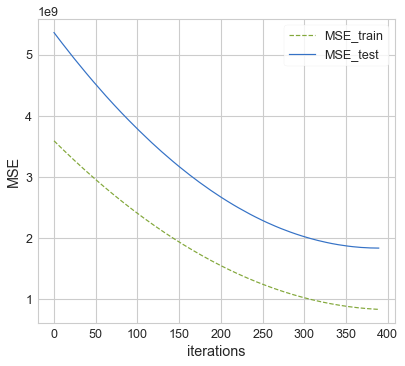

MSE on final X_test =  2170491596.571897


In [405]:
#Проведем обучение и построим график:
gamma, b_n_array = gradient_boost(X,y, lr=2.5,  depth = 5,iterations=500, debug = True)

y_pred_final = get_gradient_boost_predict(X_test ,gamma, b_n_array)
print('MSE on final X_test = ', mean_squared_error(y_test, y_pred_final))

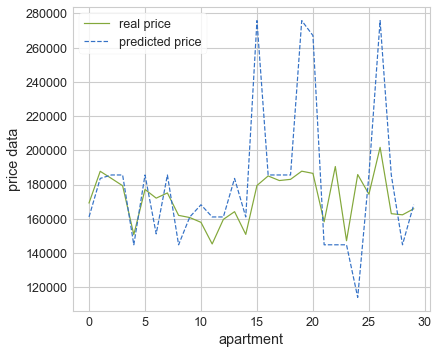

In [406]:
#Построим график y_pred и y_test на выборке отложенной в самом начале.  
plt.plot(range(30), y_test[:30],'g-', label='real price' )
plt.plot(range(30), y_pred_final[:30],'b--', label='predicted price'  )
plt.xlabel('apartment')
plt.ylabel('price data')
plt.legend(loc='best')

Модель довольно неплохо повторяет контуры - средняя линия совпадает.

### AdaBoost

In [407]:
from sklearn.ensemble import AdaBoostRegressor

In [408]:
# Собеерем Регрессор
adaboost_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5) , n_estimators=500, learning_rate=1)

In [409]:
# Обучим
adaboost_reg.fit(X_train, y_train)

y_pred = adaboost_reg.predict(X_test)
print('MSE on X_test = ', mean_squared_error(y_test, y_pred))

MSE on X_test =  1187523029.1579857


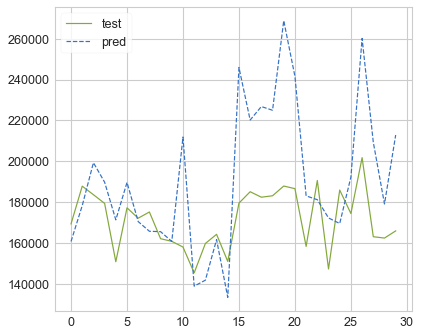

In [410]:
# Выведем на графике первые 30 точек
plt.plot(range(30), y_test[:30],'g-',label = 'test' )
plt.plot(range(30), y_pred[:30],'b--',label = 'pred')
plt.legend(loc='best')

Средняя линия не совпадает. довольно много выбросов, корреляция есть.

In [411]:
!telegram-send "Job's_Done" 

## Выводы

Был выполнен расчет датасета www.kaggle.com...iques/data (train.csv) и (test.csv)
Следующие модели были использованы:
- Случайный лес (написанный как функция),
- Случайный лес из коробки sklearn
- Стекинг с несколкими лесами и линейной регрессией (написанный как функция)
- Стекинг с несколкими лесами и линейной регрессией из коробки sklearn
- Gradient Boost (написанный как функция)
- XGBoost 
- Adaboost

Все датасеты уже были разбиты на треин и тест, внутри трейна создавалась валидационная выборка, по ней проводилась оценка обучения.  
Финальные результаты рассчитывались на тест выборке.  

Были получены следующие результаты по метрике Mean_Squared_Error:

In [426]:
results = pd.DataFrame()
results['Случайный лес функция '] = [938012653]
results['Случайный лес sklearn '] = [1864657977]
results['Стекинг функция '] = [3038480889.652186]
results['Стекинг sklearn'] = [1833252853.5998356]
results['Gradient Boost функция '] = [2170491596.571897]
results['XGBoost '] = [3038480889.652186]
results['Adaboost '] = [1187523029.1579857]
results.index = ['MSE']
results = results.T
results['root_MSE'] = results.MSE.apply(lambda x: x**0.5)
results.sort_values(['root_MSE'],ascending=True,inplace=True)
results

,MSE,root_MSE
Случайный лес функция,9.380127e+08,30626.992229
Adaboost,1.187523e+09,34460.456021
Стекинг sklearn,1.833253e+09,42816.502118
Случайный лес sklearn,1.864658e+09,43181.685666
Gradient Boost функция,2.170492e+09,46588.535034
Стекинг функция,3.038481e+09,55122.417306
XGBoost,3.038481e+09,55122.417306


1. Самые лучшие результаты - **Случайный лес на бутстрэпе (написанная функция)** показал самые лучшие результаты.  
1. С разницей в 10% от первого - **Adaboost** 